## Neural networks for segmentation

In [3]:
# ! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# ! unzip -q data.zip

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


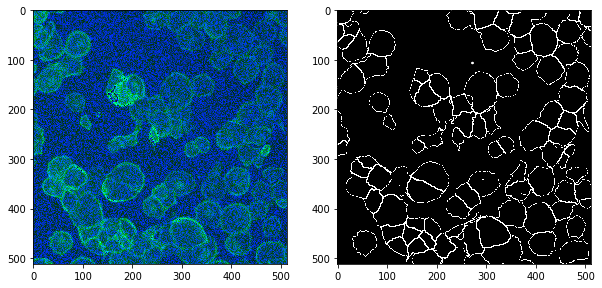

In [5]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

In [6]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [7]:
import os

import torch

import torchvision
from torchvision import transforms

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data.dataset import Dataset
import random

Я взяла основу кода для датасета с форума https://discuss.pytorch.org/t/torchvision-transfors-how-to-perform-identical-transform-on-both-image-and-target/10606/7

In [241]:
import torchvision.transforms.functional as TF

class SegmentationDataset(Dataset):
    def __init__(self, image_paths=None, target_paths=None, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.train = train

    def transform(self, image, mask):
        # Resize
        if self.train:

            # Random vertical flipping
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

            # Random rotate
            angle = np.random.uniform(0, 50)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        
            
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask) > 0.01
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        if self.target_paths:
            mask = Image.open(self.target_paths[index])
        else:
            mask = Image.open(self.image_paths[index])
            x, y = self.transform(image, mask)
            return x, self.image_paths[index]
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)


In [27]:
train_filenames = os.listdir('train/images/')
train_images_path = ['train/images/' + fname for fname in train_filenames]
train_masks_path = ['train/masks/' + fname for fname in train_filenames]

val_filenames = os.listdir('val/images/')
val_images_path = ['val/images/' + fname for fname in val_filenames]
val_masks_path = ['val/masks/' + fname for fname in val_filenames]

In [28]:
train_dataset = SegmentationDataset(image_paths=train_images_path, target_paths=train_masks_path)

In [29]:
val_dataset = SegmentationDataset(image_paths=val_images_path, target_paths=val_masks_path, train=False)

In [30]:
batch_size = 7
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

In [31]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

In [32]:
import itertools

In [35]:
class MyUnet(nn.Module):
    def __init__(self, filters):
        super(MyUnet, self).__init__()
        self.filters = filters

        encoder_layers = []
        in_filters = 3
        for i, ifilters in enumerate(filters):            
            encoder_layers.append(nn.ModuleList([
                nn.MaxPool2d(2),

                nn.Conv2d(in_filters, ifilters, kernel_size=3, padding=1),
                nn.BatchNorm2d(ifilters),
                nn.ReLU(),

                nn.Conv2d(ifilters, ifilters, kernel_size=3, padding=1),
                nn.BatchNorm2d(ifilters),
                nn.ReLU(),
            ]))
            in_filters = ifilters
        self.encoder_list = encoder_layers
        [self.add_module('encoder_' + str(i), layer) for i, layer in enumerate(list(itertools.chain(*self.encoder_list)))]

        decoder_layers = []
        for i in range(len(filters) - 1):
            print(i)
            print('filters ', -i -2,  '', filters[-i-2])
            decoder_layers.append(([
                nn.ConvTranspose2d(filters[-i - 1], filters[-i - 2], kernel_size=2, stride=2),
                nn.Conv2d(filters[-i - 1], filters[-i - 2], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[-i - 2]),
                nn.ReLU(),

                nn.Conv2d(filters[-i - 2], filters[-i - 2], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[-i - 2]),
                nn.ReLU()
                ]))
        decoder_layers.append(
            ([nn.ConvTranspose2d(filters[0], filters[0], kernel_size=2, stride=2)]))
        
        self.decoder_list = decoder_layers
        self.encoder_outputs = []
        [self.add_module('decoder_' + str(i), layer) for i, layer in enumerate(list(itertools.chain(*self.decoder_list)))]
        
        self.head_list = [nn.Conv2d(filters[0], 1, kernel_size=1), nn.Sigmoid()]
        [self.add_module('my_head' + str(i), layer) for i, layer in enumerate(self.head_list)]

    def encoder(self, x):
        output = x
        for i, block in enumerate(self.encoder_list):
            for j, layer in enumerate(block):
                output = layer(output)
            self.encoder_outputs.append(output)
        return output

    def decoder(self, x):
        output = x
        for i, block in enumerate(self.decoder_list[:-1]):
            upsampled_x = block[0](output)
            encoder_tensor = self.encoder_outputs[-i - 2]
            output = torch.cat([encoder_tensor, upsampled_x], 1)
            for j, layer in enumerate(block[1:]):
                output = layer(output)
        output = self.decoder_list[-1][0](output)
        return output
            
    def forward(self, x):
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)
        output = self.head_list[0](decoder_output)
        self.encoder_outputs = []
        return self.head_list[1](output)
#         print(' output tensor ', output.device)
#         return output

In [36]:
model = MyUnet([24, 48, 96, 192])

0
filters  -2  96
1
filters  -3  48
2
filters  -4  24


In [37]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, predictions, targets):

        targets = targets.view(-1).type(torch.FloatTensor).cuda()
        predictions = predictions.view(-1)
        probs = predictions

        per_entry_cross_ent = - targets * ((1 - probs) ** self.gamma) * torch.log(torch.clamp(probs, 1e-8, 1.0)) \
                      - (1 - targets) * (probs ** self.gamma) * torch.log(torch.clamp(1.0 - probs, 1e-8, 1.0))      
        return torch.mean(per_entry_cross_ent)


In [39]:
def compute_loss(X_batch, y_batch):
    torch.cuda.empty_cache()
    X_batch = torch.FloatTensor(X_batch).cuda()
    y_batch = torch.FloatTensor(y_batch).cuda()
    logits = model.cuda()(X_batch)
    

    y_batch = y_batch.view(y_batch.size(0), -1)
    y_predicted = (logits.view(X_batch.size(0), -1))
    return FocalLoss(gamma=0.0).forward(y_predicted, y_batch)

In [42]:
opt = torch.optim.Adam(model.parameters())
# , lr=0.005)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 274
batch_size = 7  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        torch.cuda.empty_cache()
        loss = compute_loss(X_batch, y_batch.float())
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss.append(loss.detach().cpu().data.numpy())
    print (num_epochs)

    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:

        logits = model(Variable(torch.FloatTensor(X_batch)).cuda()).data.cpu().numpy()
        y_pred = (logits > 0.3).astype(np.float32)

        val_accuracy.append(calc_iou(y_pred, y_batch.cpu().numpy()))
        torch.cuda.empty_cache()
    print (num_epochs)
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

So we achieved the goal accuracy on validation! Ta-dam!

# Predict on test data

In [107]:
k = 0

In [108]:
treshold_accs = []
for treshold in [0.23, 0.24, 0.25, 0.27, 0.3, 0.32, 0.35]:
    for X_batch, y_batch in val_batch_gen:
        k += 1
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda()).data.cpu().numpy()
        y_pred = (logits > treshold).astype(np.float32)
        treshold_accs.append(calc_iou(y_pred, y_batch.cpu().numpy()))

In [112]:
len(treshold_accs) == k

True

In [114]:
np.argmax(np.array(treshold_accs))

1

In [244]:
test_fnames = os.listdir('test/images/')
test_images_path = ['test/images/' + fname for fname in test_fnames]

In [245]:
test_dataset = SegmentationDataset(image_paths=test_images_path, train=False)

In [255]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=len(test_fnames),
                                              shuffle=False)

In [256]:
predictions = []

In [257]:
predicted_fnames = []
for X_batch, fname in test_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda()).data.cpu().numpy()
    predicted_fnames.append(fname)

In [260]:
predicted_fnames[0][0]

'test/images/05899.png'

In [261]:
X_batch.data.numpy().shape

(7, 3, 512, 512)

In [262]:
images = X_batch.data.numpy().swapaxes(1, 3).swapaxes(1, 2)

In [263]:
predicted_masks = (logits > 0.24).astype(np.float32)

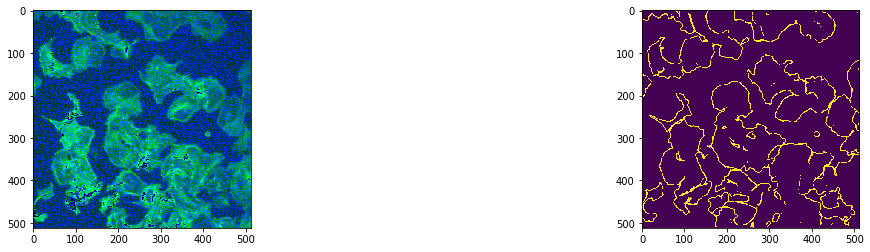

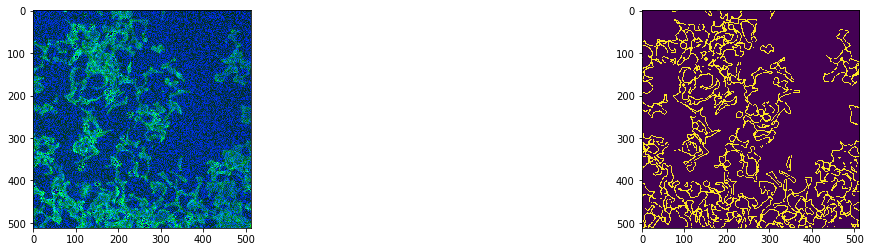

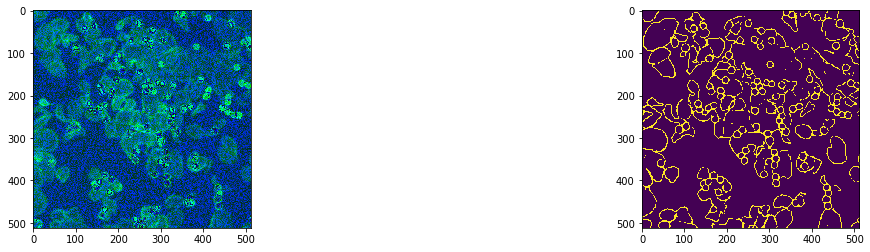

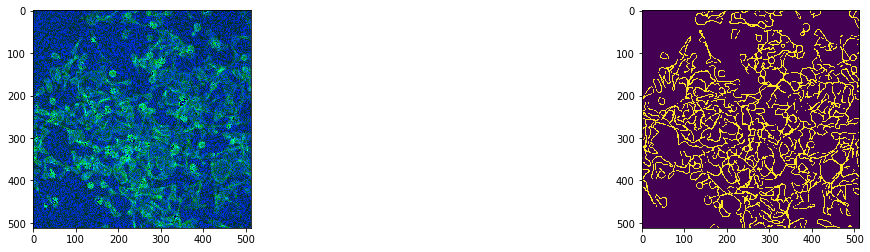

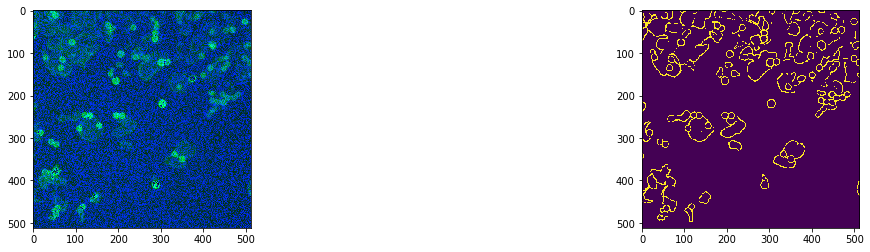

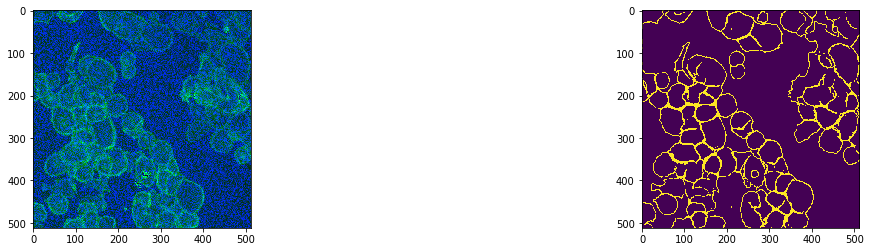

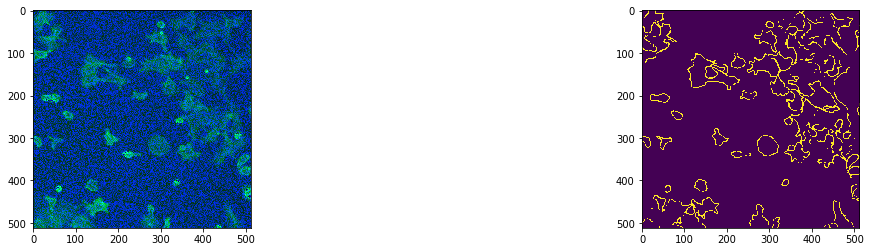

In [264]:
for i in range(7):
    _, axes = plt.subplots(1, 2, figsize=(20, 4))
    axes[0].imshow(images[i])
    axes[1].imshow(predicted_masks[i, 0, :, :])
    plt.show()

In [265]:
predicted_masks_int = (predicted_masks * 255).astype(np.uint8)

In [266]:
predicted_masks_int.dtype

dtype('uint8')

In [267]:
np.unique(predicted_masks_int)

array([  0, 255], dtype=uint8)

In [268]:
predicted_masks_int.shape

(7, 1, 512, 512)

In [274]:
predicted_fnames[0][0][-10:]

'/05899.png'

# Save masks

In [275]:
for i in range(7):
    mask = Image.fromarray(predicted_masks_int[i, 0, :, :])
    mask.save('test/predicted_masks/' + predicted_fnames[0][i][-9:])

Check if names are correct

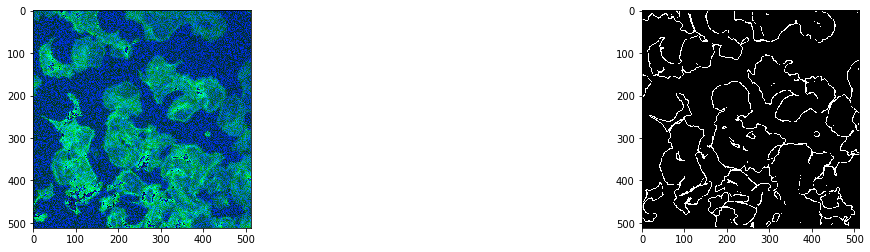

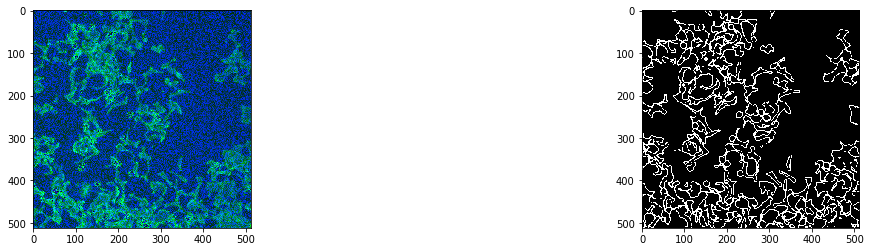

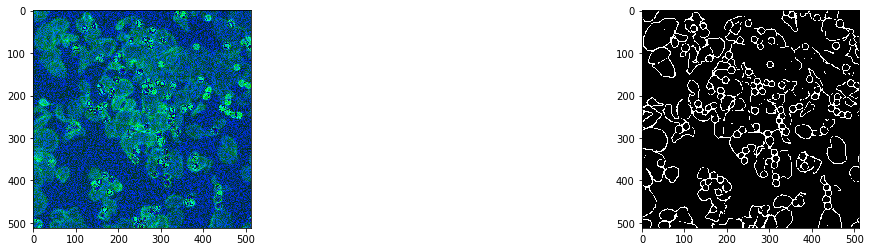

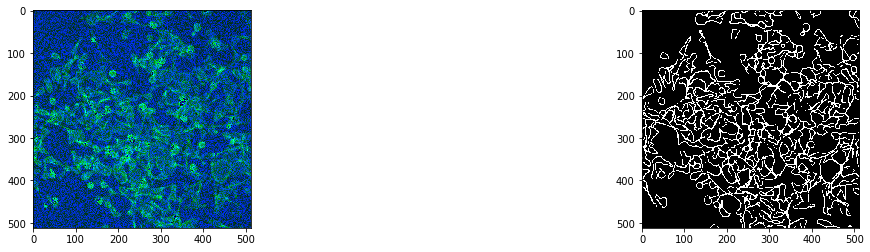

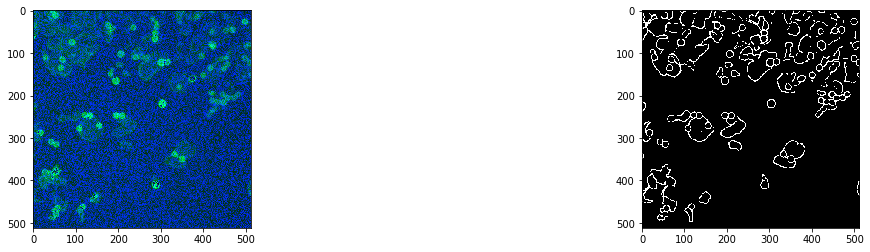

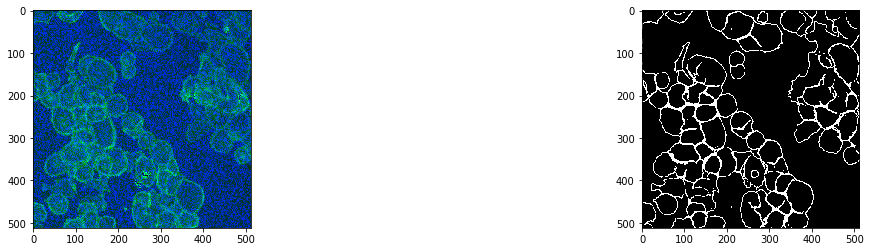

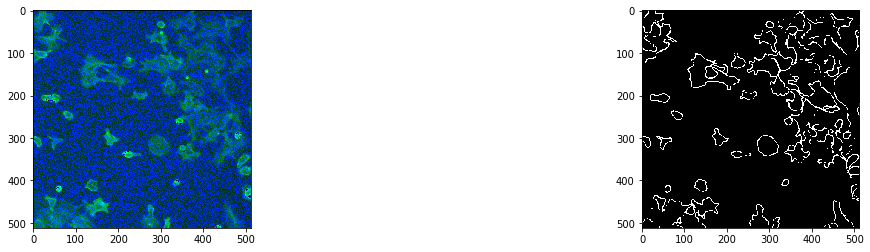

In [276]:
for fname in test_fnames:
    image = Image.open('test/images/' + fname)
    mask = Image.open('test/predicted_masks/' + fname)
    _, axes = plt.subplots(1, 2, figsize=(20, 4))
    axes[0].imshow(image)
    axes[1].imshow(mask)
    plt.show()